# Часть 1. Анализ активности пользователей книжного приложения в Москве и Санкт-Петербурге

- Автор: Клементьев В.Д.
- Дата: 22.05.2025

## Цели и задачи проекта

Целью проекта является проверка гипотезы A/B-тестом. Основные задачи включают подготовку данных к анализу, начиная с очистки от дубликатов, проверки распределения пользователей между тестовой и контрольной группами, а также корректного разделения трафика. Заключительный этап предполагает статистическую оценку результатов.

## Описание данных

`user_id` — идентификатор пользователя;  
`group` — группа пользователя;  
`ab_test` — название теста;  
`device` — устройство, с которого происходила регистрация.

## Содержимое проекта

1. Загрузка данных и знакомство с ними
2. Проверка гипотезы в Python

## 1. Загрузка данных и знакомство с ними
Начнём с загрузки библиотек и датасета. Будем использовать pandas и библиотеки для проведения статистических тестов. Данные датасета сохраним в переменную `books_data`.

In [1]:
# Импортируем библиотеки
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Выгружаем данные
books_data = pd.read_csv('yandex_knigi_data.csv')

Познакомимся с данными датасетов — выведем первые строки методом `head()` и информацию методом `info()`:

In [3]:
# Выводим первые строки датафрейма
books_data.head()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


In [4]:
# Выводим информацию о датафрейме
books_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


В датафрейме нет пропусков, все показатели имеют корректный тип данных. Но столбец `Unnamed: 0` не несет полезной информации, удалим его.

In [5]:
# Очищаем датафрейм от ненужных данных
books_data.drop(columns=['Unnamed: 0'], inplace=True)

Теперь проверим данные на наличие явных и неявных дубликатов. Начнём с полных дубликатов:

In [6]:
# Проверяем полные дубликаты в датафрейме books_data
print(books_data.duplicated().sum())

0


В датафреймах нет полных дубликатов строк. Проверим неявные дубликаты — значения по `puid` пользователей должны быть уникальными, то есть каждая строка в данных — уникальный пользователь:

In [7]:
# Проверяем неявные дубликаты в датафрейме books_data
print(books_data.duplicated(subset='puid').sum())

244


В данных присутствует 244 дубликата по полю `puid`, что нарушает условие уникальности пользователей. Удалим их:

In [8]:
# Удаляем дубликаты в поле puid
books_data.drop_duplicates(subset=['puid'], inplace=True)

Разделим исходные данные по городам и посмотрим, пересекаются ли пользователи в двух группах.

In [9]:
# Разделение на группы
msk = books_data[books_data['city'] == 'Москва']
spb = books_data[books_data['city'] == 'Санкт-Петербург']

# Создаем множества с пользователями
set_msk = set(msk['puid'])
set_spb = set(spb['puid'])

common_users = set_msk & set_spb

# Выводим результат
if not common_users:
    print('Группы независимы')
else:
    print('Группы зависимы')

Группы независимы


Группы также должны быть сопоставимы, то есть иметь схожий размер и описательную статистику. Начнем со сравнения размеров.

In [10]:
# Считаем уникальных пользователей по группам
test_a = msk['puid'].nunique()
test_b = spb['puid'].nunique()

# Находим процентную разницу в количестве пользователей
p = abs(test_a - test_b) / test_a * 100

# Выводим результат
print(f'Количество пользователей в группе А: {test_a}\n'
      f'Количество пользователей в группе B: {test_b}\n'
      f'P = {p}')

Количество пользователей в группе А: 6234
Количество пользователей в группе B: 2306
P = 63.0093038177735


Выборка test_a имеет значительное преимущество по численности. При такой разнице результаты будут искажены. Используем random sampling с балансировкой, чтобы выровнять группы по размеру.

In [11]:
# Вычислим долю для баланса 
sample_fraction = test_b / test_a

# Случайный отбор уникальных puid
balanced_sample = msk['puid'].sample(frac=sample_fraction, random_state=42)

# Фильтруем выборку
msk = msk[msk['puid'].isin(balanced_sample)]

Размеры выровнены, теперь посмотрим, схожа ли описательная статистика.

In [12]:
# Выводим описательную статистику
msk['hours'].describe()

count    2306.000000
mean       10.373775
std        33.038647
min         0.000022
25%         0.067847
50%         0.917756
75%         5.683398
max       462.609644
Name: hours, dtype: float64

In [13]:
# Выводим описательную статистику
spb['hours'].describe()

count    2306.000000
mean       11.264433
std        39.831755
min         0.000025
25%         0.060173
50%         0.875355
75%         6.138424
max       978.764775
Name: hours, dtype: float64

- средние и медианы сильно различаются, что говорит о правом асимметричном распределении  
- максимальные занчения аномально высоки по сравнению с 3 квартилем  
- стандартные отклонения большие

Распределения имеют выбросы, поэтому для проверки гипотезы отфильтруем выборки и используем t-тест с поправкой Уэлча.

In [14]:
# Усекаем данные до 85 квантиля
filtered_msk = msk[msk['hours'] <= msk['hours'].quantile(0.85)]
filtered_spb = spb[spb['hours'] <= spb['hours'].quantile(0.85)]

## Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [15]:
# Устанавливаем уровень значимости
alpha = 0.05

stat_welch_ttest, p_value_welch_ttest = ttest_ind(
    filtered_msk['hours'], 
    filtered_spb['hours'], 
    equal_var=False,
    alternative='greater')

if p_value_welch_ttest > alpha:
    print(f'pvalue = {round(p_value_welch_ttest, 2)} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны')
else:
    print(f'pvalue = {round(p_value_welch_ttest, 2)} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Распределения метрики в группах A и B различаются')

pvalue = 0.9 > 0.05
Нулевая гипотеза находит подтверждение! Распределения метрики в группах A и B равны


Тест не показал статистически значимых различий. Следовательно, средняя активность пользователей в обоих городах одинакова.

В результате подготовки данных к проведению статистического теста было выяснено, что выборки имеют аномальные значения. По этой причине было решено отфильтровать данные и использовать t-тест с поправкой Уэлча и уровнем значимости 0.05, так как это общепринятый стандарт для цифровых исследований. Результаты теста показали, что оснований для отвержения нулевой гипотезы недостаточно, поэтому средняя активность пользователей не отличается. Из возможных причин отсутствия результата: одинаковые маркетинговые условия или схожие аудитории.

# Часть 2. Анализ результатов A/B-тестирования

BitMotion Kit — интернет-магазин геймифицированных товаров для ЗОЖ, столкнувшийся с проблемой сложного интерфейса. Для решения этой проблемы была разработана новая версия сайта и проведен A/B-тест с целью:

- Упростить пользовательский интерфейс

- Увеличить конверсию в покупки

- Подготовиться к расширению ассортимента

## Цель исследования.
Цель исследования — оценить корректность проведения теста и проанализировать его результаты.

## Описание данных

Таблица `participants`:  
`user_id` — идентификатор пользователя  
`group` — группа пользователя  
`ab_test` — название теста  
`device` — устройство, с которого происходила регистрация  

Таблица `events`:  
`user_id` — идентификатор пользователя  
`event_dt` — дата и время события  
`event_name` — тип события  
`details` — дополнительные данные о событии

## Содержимое проекта

1. Загрузка данных и оценка их целостности
2. Оценка корректности проведения теста
3. Оценка результатов A/B-тестирования

## 1. Загрузка данных и оценка их целостности.
Познакомимся с данными датасетов — выведем первые строки методом `head()` и информацию методом `info()`:

In [16]:
# Выгружаем данные
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [17]:
# Выводим первые строки датафреймов
display(participants.head(), events.head())

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [18]:
# Выводим информацию о датафреймах 
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [19]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Датафрейм `participants` хранит информацию об участниках тестов, в нем отсутвуют null-значения, все столбцы имеют корректный тип данных. `events` содержит данные о событиях, связанных с активностью пользователей. В нем пристуствуют пропущенные значения (`details`) и события, не связанные с конкретным пользователем (GLOBAL в `user_id`). Отфильтруем строки с GLOBAL и выделим их в отдельную группу.

In [20]:
# Выделяем GLOBAL в отдельную группу
global_events = events[events['user_id'] == 'GLOBAL']

# Фильтруем events
events = events[events['user_id'] != 'GLOBAL']

## 2. Оценка корректности проведения теста:

Выделим пользователей, участвующих в тесте, и проверим:

- равномерность распределения пользователей по группам теста,

- отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [21]:
# Выделяем пользователей, участвующих в тесте
interface_participants = participants[participants['ab_test'] == 'interface_eu_test']

Теперь сравним распределния пользователей по A и B группам. 

In [22]:
# Вычисляем доли по группам
group_shares = interface_participants['group'].value_counts(normalize=True) * 100

# Выводим на экран
print(f'Распределение по группам в %:\n{group_shares}')

Распределение по группам в %:
group
B    50.387097
A    49.612903
Name: proportion, dtype: float64


Разница незначительная, пользователи распределены равномерно. Теперь посмотрим, не пересекаются ли другие тесты с `interface_eu_test`.

In [23]:
# Создаем множества с пользователями
set_a = set(interface_participants['user_id'])
set_b = set(participants[
    participants['ab_test'] != 'interface_eu_test'
]['user_id'])

common_users = set_a & set_b

# Выводим результат
if not common_users:
    print('Нет пересечений с конкурирующими тестами')
else:
    print(f'Есть пересечения с конкурирующими тестами : {len(common_users)}')

Есть пересечения с конкурирующими тестами : 887


887 общих пользователей. Отфильтруем `interface_participants` от пересечений с другими тестами. 

In [24]:
# Фильтруем датафрейм от пересечений
interface_participants = interface_participants[
    ~interface_participants['user_id'].isin(common_users)
]

Проанализируем данные о пользовательской активности, оставим только события, связанные с участвующими в изучаемом тесте пользователями

In [25]:
# Объединяем события с участниками теста
interface_events = pd.merge(
    events,
    interface_participants,
    on='user_id',
    how='inner'
)

Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации

In [26]:
# Фильтруем события регистрации
registrations = interface_events[interface_events['event_name'] == 'registration']

# Для каждого user_id берем дату регистрации
registration_dates = (registrations.groupby('user_id')
                      .agg(registration_dt=('event_dt', 'min'))
                      .reset_index())

# Объединяем все события с датами регистрации
interface_events = pd.merge(
    interface_events,
    registration_dates,
    on='user_id',
    how='inner'
)

# Рассчитываем лайфтайм в днях
interface_events['lifetime_days'] = (
    (interface_events['event_dt'] - interface_events['registration_dt'])
    .dt.days
)

# Фильтруем по первым 7 дням
first_week_events = interface_events[
    (interface_events['lifetime_days'] >= 0) & 
    (interface_events['lifetime_days'] <= 6)
]

Оценим достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- достоверность теста — 95%.

Поскольку тестируемая метрика долевая, воспользуемся калькулятором Эвана-Миллера.

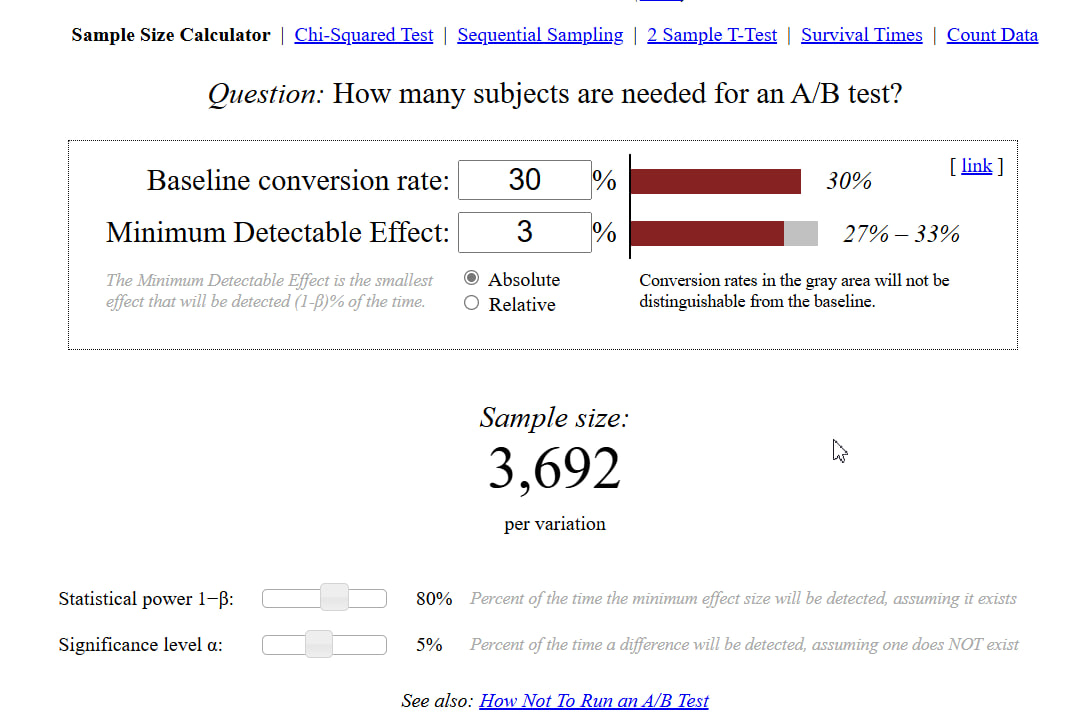

Размер выборки на группу составляет 3692

Рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [28]:
# Для каждого пользователя определяем, была ли покупка
user_stats = (
    first_week_events
    .groupby(['group', 'user_id'])
    .agg(is_purchase=('event_name', lambda x: (x == 'purchase').any()))
    .reset_index()
)

# Считаем пользователей по категориям
conversion_stats = (
    user_stats
    .groupby('group')
    .agg(
        total_users=('user_id', 'count'),
        purchasers=('is_purchase', 'sum')
    )
)

# Считаем конверсию
conversion_stats['conversion_rate'] = (
    round((conversion_stats['purchasers'] / conversion_stats['total_users']) * 100) 
)

# Выводим таблицу
print(conversion_stats)

       total_users  purchasers  conversion_rate
group                                          
A             4952        1377             28.0
B             5011        1480             30.0


После изменения интерфейса конверсия в покупателя увеличилась, но меньше чем на 3 %. Однако говорить о значимых изменениях можно только после проведения статистического теста. 

## 3. Оценка результатов A/B-тестирования:

Так как тестируемая метрика долевая, воспользуемся Z-тестом пропорций. Проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок и сформулируем гипотезы:
- Нулевая гипотеза H<sub>0</sub>: Доля покупателей в группе A и B не различается.

- Альтернативная гипотеза H<sub>1</sub>: Доля покупателей в группе A меньше, чем в группе B, и это различие статистически значимо.


In [29]:
n_a, n_b = conversion_stats.loc['A', 'total_users'], conversion_stats.loc['B', 'total_users'] # размеры выборок

m_a = conversion_stats.loc['A', 'purchasers'] # количество успехов в группе A
m_b = conversion_stats.loc['B', 'purchasers'] # количество успехов в группе B

p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

n_a=4952, n_b=5011
m_a=1377, m_b=1480
p_a=0.27806946688206785, p_b=0.29535022949511075
Предпосылка о достаточном количестве данных выполняется!


In [30]:
# Устанавливаем уровень значимости
alpha = 0.05

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.028262547212292124 < 0.05
Нулевая гипотеза не находит подтверждения!


Нулевая гипотеза отвергнута, а это значит, что изменение интерфейса действительно увеличило конверсию в покупку.

На основании проведённого A/B-теста наблюдается статистически значимое увеличение конверсии с 28% до 30%. Рекомендуется внедрить изменение интерфейса для всех пользователей.